In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.preprocessing import CorrelationRemover

In [2]:
# Ignoring warnings (many warnings come from the FairLearn package)
import warnings
warnings.filterwarnings('ignore')

#### Reading in the data and getting an overview

In [3]:
# Starting with 35k observations that have NA values filled from KNN imputation
df = pd.read_csv('na_filled_df.csv').sample(n=35000, random_state=2025)
print(df.shape)
print(df.columns)

(35000, 21)
Index(['action_taken', 'preapproval', 'property_value', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'open-end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
       'loan_term', 'negative_amortization', 'occupancy_type', 'income',
       'debt_to_income_ratio', 'applicant_sex', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_race', 'applicant_age_above_62'],
      dtype='object')


****

### Formatting the data

In [4]:
# Finding categorical variables
string_columns = df.select_dtypes(include=['object']).columns
string_df = df[string_columns].copy()
print(string_columns)
sensitive_features = df[['derived_race']].copy()

Index(['applicant_sex', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_race', 'applicant_age_above_62'],
      dtype='object')


In [5]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)

In [6]:
# Correlation remover can only use numeric data, so removing string data
df0 = df.copy()
df0 = df0.drop(columns=[col for col in string_columns if col not in sensitive_features])
# Dropping target variable
df0 = df0.drop(columns=['action_taken'])

In [8]:
# Saving the target variable
target_variable_df = df['action_taken'].to_frame()
df_dummies = pd.get_dummies(df0, columns=sensitive_features.columns, drop_first=True)

## Pre processing the data

In [9]:
# Update the sensitive feature list to match the one-hot encoded column names
sensitive_features_dummies = [col for col in df_dummies.columns if 'applicant_sex' in col or 'applicant_age_above_62' in col or 'derived_race' in col]

# Initialize the CorrelationRemover
cr = CorrelationRemover(sensitive_feature_ids=sensitive_features_dummies, alpha=1)

# Fit and transform the data
transformed_data = cr.fit_transform(df_dummies)

# Create a new DataFrame with the transformed data and the same column names
transformed_df = pd.DataFrame(transformed_data, columns=[col for col in df_dummies.columns if col not in sensitive_features_dummies], index=df_dummies.index)

In [10]:
# Merging the transformed numeric data back together with the string data
final_df = pd.concat([transformed_df, string_df, target_variable_df], axis=1)

In [11]:
final_df_dummies = pd.get_dummies(final_df, columns=['applicant_sex', 'applicant_age_above_62', 'derived_race'], drop_first=True)

df_dummies = pd.get_dummies(df, columns=['applicant_sex', 'applicant_age_above_62', 'derived_race'], drop_first=True)

## Comparing new correlations to old correlations

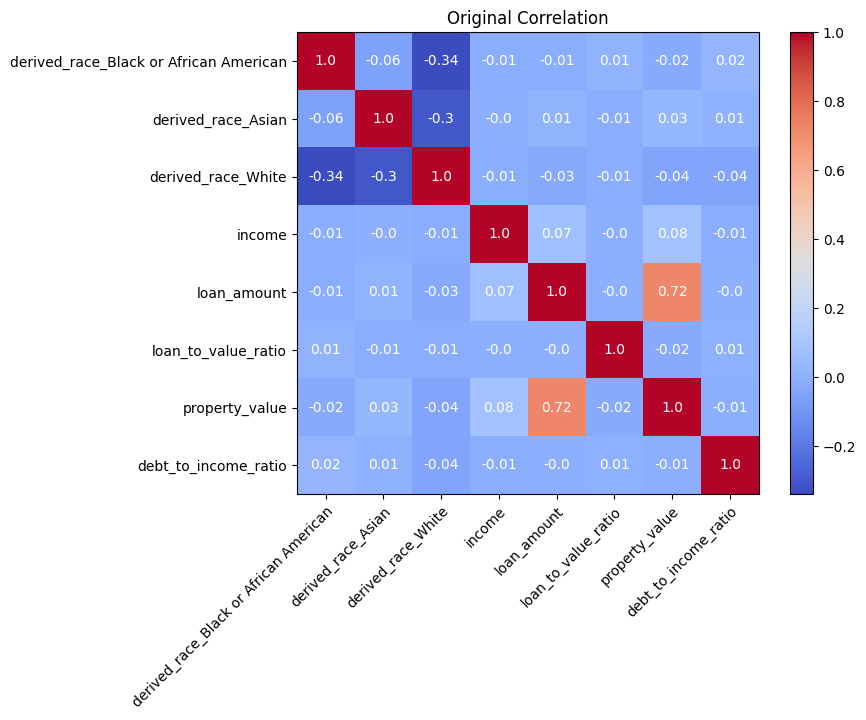

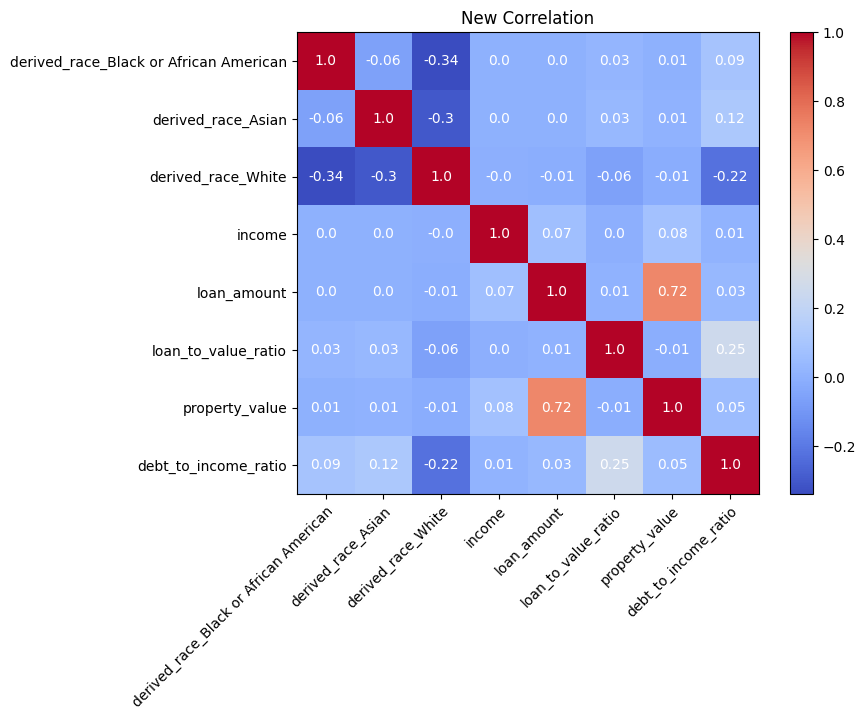

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(df, title, features):
    # Ensure the features list only contains columns present in the DataFrame
    valid_features = [feature for feature in features if feature in df.columns]

    # Creating a smaller DataFrame with the selected columns
    smaller_df = df[valid_features]

    # Compute correlation
    corr_matrix = smaller_df.corr()
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(corr_matrix, cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(smaller_df.columns)))
    ax.set_xticklabels(smaller_df.columns)
    ax.set_yticks(np.arange(len(smaller_df.columns)))
    ax.set_yticklabels(smaller_df.columns)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(smaller_df.columns)):
        for j in range(len(smaller_df.columns)):
            ax.text(j, i, round(corr_matrix.to_numpy()[i, j], 2), ha="center", va="center", color="w")

    ax.set_title(f"{title}")
    fig.colorbar(cax)
    plt.show()

# Testing the function
features_to_plot = ['derived_race_Black or African American', 'derived_race_Asian', 'derived_race_White',
       'income','loan_amount', 'loan_to_value_ratio', 'property_value', 'debt_to_income_ratio']
plot_heatmap(df_dummies, "Original Correlation", features_to_plot)
plot_heatmap(final_df_dummies, "New Correlation", features_to_plot)

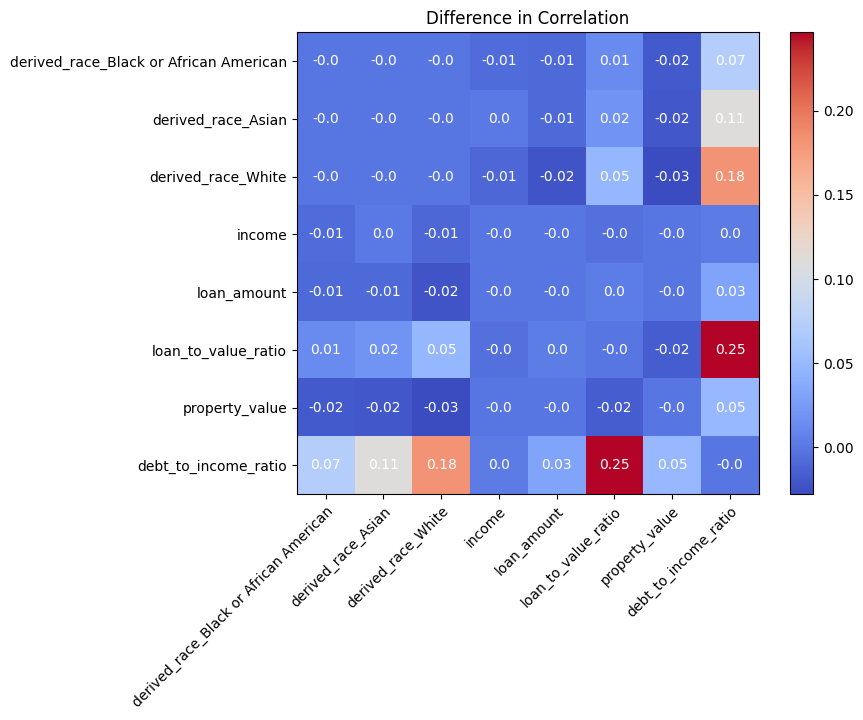

In [13]:
def get_corr_matrix(df, features):
    valid_features = [feature for feature in features if feature in df.columns]
    smaller_df = df[valid_features]
    return smaller_df.corr()

def plot_heatmap_difference(df1, df2, features, title):
    # Get the correlation matrices for each DataFrame
    corr_matrix_1 = get_corr_matrix(df1, features)
    corr_matrix_2 = get_corr_matrix(df2, features)

    # Calculate the difference
    abs_corr_matrix_1 = abs(corr_matrix_1)
    abs_corr_matrix_2 = abs(corr_matrix_2)
    diff_corr_matrix = -(abs_corr_matrix_1 - abs_corr_matrix_2)

    # Plot the difference heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(diff_corr_matrix, cmap="coolwarm")
    ax.set_xticks(np.arange(len(features)))
    ax.set_xticklabels(features)
    ax.set_yticks(np.arange(len(features)))
    ax.set_yticklabels(features)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(features)):
        for j in range(len(features)):
            ax.text(j, i, round(diff_corr_matrix.to_numpy()[i, j], 2), ha="center", va="center", color="w")

    ax.set_title(f"{title}")
    fig.colorbar(cax)
    plt.show()

features_to_plot = ['derived_race_Black or African American', 'derived_race_Asian', 'derived_race_White',
       'income','loan_amount', 'loan_to_value_ratio', 'property_value', 'debt_to_income_ratio']
plot_heatmap_difference(df_dummies, final_df_dummies, features_to_plot, "Difference in Correlation")


****

## Building a random forest model

In [14]:
# Create dummy variables for the random forest model
string_columns = final_df.select_dtypes(include=['object']).columns
df_dummies = pd.get_dummies(final_df, columns=string_columns, drop_first=True)

In [15]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

In [16]:
# Building the random forest model
np.random.seed(2023)
rf0 = RandomForestClassifier(n_estimators=100, random_state=2023)
rf0.fit(X_train, y_train)

# Generating predictions and displaying the confusion matrix
y_pred = rf0.predict(X_test)

Accuracy: 0.7630
Precision: 0.7799
Recall: 0.9090
F1 Score: 0.8395
Confusion Matrix:


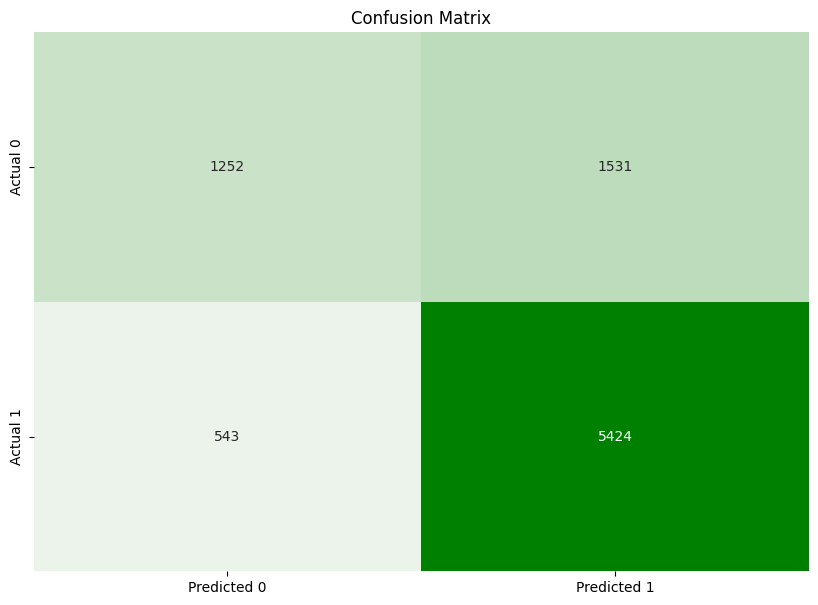

In [17]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

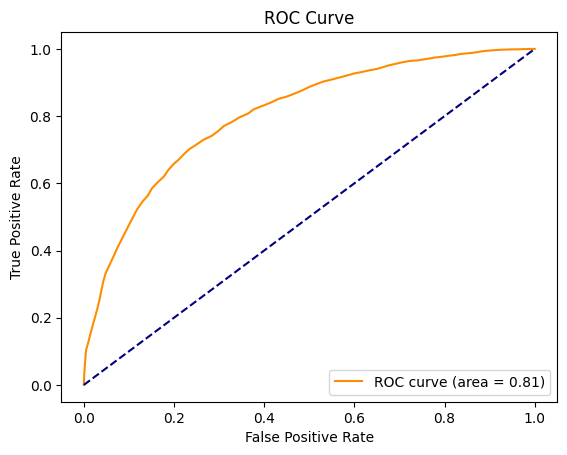

In [18]:
# Plotting the ROC curve
y_prob = rf0.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
importances = rf0.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
sorted_features = [X.columns[idx] for idx in sorted_indices]

sorted_features_with_importance = []
for i, idx in enumerate(sorted_indices):
    feature_name = X.columns[idx]
    importance_value = importances[idx]
    print(f"{i + 1}. {feature_name} ({importance_value})")
    sorted_features_with_importance.append((feature_name, importance_value))

****

## Looking into metrics with Microsoft Fairlearn

In [ ]:
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import selection_rate

In [ ]:
# Accuracy by race
mf = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(mf.overall)
mf.by_group

In [ ]:
# Selection rate is the percentage of the population that is labeled '1'
sr = MetricFrame(metrics=selection_rate, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])
print(sr.overall)
sr.by_group

In [ ]:
# Manually defining positives and negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

### Applicant sex

In [ ]:
metrics = {
    "accuracy": accuracy_score,
    "precision": precision_score,
    "recall": recall_score,
    "F1 score": f1_score,
    "false positive rate": false_positive_rate,
    "false negative rate": false_negative_rate,
    "selection rate": selection_rate,
    "count": count,
}
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_sex'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

### Applicant race

In [ ]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features_test['derived_race'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

### Applicant age above 62

In [ ]:
metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, 
    y_pred=y_pred, sensitive_features=sensitive_features_test['applicant_age_above_62'])

metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

In [ ]:
# Same info as the graph above but in table format

# Create a rounded table
rounded_table = metric_frame.by_group.round(3)

# Display the table
print(rounded_table)

In [ ]:
""" # Getting errors for race and sex metrics. It seems that some groups are too small and causing errors.
print(df['derived_race'].value_counts()/len(df)*100)
sns.countplot(x='derived_race', data=df) """

### Updating the objective function with Exponentiated Gradient mitigation  using Demographic Parity as the objective

In [ ]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient

In [ ]:
np.random.seed(2023)

constraint = EqualizedOdds()
classifier = RandomForestClassifier(n_estimators=100, random_state=2023)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_features_train['applicant_sex'])

y_pred_mitigated = mitigator.predict(X_test)

### Comparing mitigated to original

In [ ]:
# Define the metrics
metrics_list = ['false_positive_rate', 'false_negative_rate', 'f1_score']

# Initialize an empty dictionary to hold the metrics
metrics_dict = {
    'FPR Male': [],
    'FPR Female': [],
    'FPR Other/NA': [],
    'FNR Male': [],
    'FNR Female': [],
    'FNR Other/NA': [],
    'F1 Male': [],
    'F1 Female': [],
    'F1 Other/NA': []
}

# Populate the dictionary with the metric values for mitigated and original models
for metric_name in metrics_list:
    for group in ['Male', 'Female', 'Other/NA']:
        mitigated_metric = metric_frame_mitigated.by_group[metric_name][group].round(3) if metric_name in metric_frame_mitigated.by_group else None
        original_metric = metric_frame_original.by_group[metric_name][group].round(3) if metric_name in metric_frame_original.by_group else None
        key_suffix = 'FPR' if metric_name == 'false_positive_rate' else 'FNR' if metric_name == 'false_negative_rate' else 'F1'
        metrics_dict[f'{key_suffix} {group}'].append(mitigated_metric)
        metrics_dict[f'{key_suffix} {group}'].append(original_metric)

# Create the DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Mitigated', 'Original'])

# Display the DataFrame
print(metrics_df)

In [ ]:
# Define the metrics
metrics = {
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'f1_score': f1_score,
}

# Calculate metrics for the mitigated model
metric_frame_mitigated = MetricFrame(metrics=metrics,
                                     y_true=y_test,
                                     y_pred=y_pred_mitigated,
                                     sensitive_features=sensitive_features_test['applicant_sex'])

# Calculate metrics for the original model
metric_frame_original = MetricFrame(metrics=metrics,
                                    y_true=y_test,
                                    y_pred=y_pred,
                                    sensitive_features=sensitive_features_test['applicant_sex'])

# Create a dictionary to hold the overall metrics for mitigated and original models
overall_metrics_dict = {
    'FPR': [
        metric_frame_mitigated.overall['false_positive_rate'].round(3),
        metric_frame_original.overall['false_positive_rate'].round(3)
    ],
    'FNR': [
        metric_frame_mitigated.overall['false_negative_rate'].round(3),
        metric_frame_original.overall['false_negative_rate'].round(3)
    ],
    'F1 Score': [
        metric_frame_mitigated.overall['f1_score'].round(3),
        metric_frame_original.overall['f1_score'].round(3)
    ]
}

# Create the DataFrame with 'Mitigated' and 'Original' as the index
overall_metrics_df = pd.DataFrame(overall_metrics_dict, index=['Mitigated', 'Original'])

# Display the DataFrame
print('Overall metrics')
print(overall_metrics_df)


### Looking at post processing

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer

# Setup the postprocessed model
postprocessed_model = ThresholdOptimizer(
    estimator= rf0,
    constraints='false_negative_rate_parity',
    objective='balanced_accuracy_score',
    prefit=True  # Since the estimator is already fitted
)

# Fit the ThresholdOptimizer
# Remember to use the test set to avoid data leakage
postprocessed_model.fit(X_test, y_test, sensitive_features=sensitive_features_test['applicant_sex'])

# Generate mitigated predictions
y_pred_postprocessed = postprocessed_model.predict(X_test, sensitive_features=sensitive_features_test['applicant_sex'])


In [ ]:
# Define the metrics
metrics = {
    'false_positive_rate': false_positive_rate,
    'false_negative_rate': false_negative_rate,
    'f1_score': f1_score
}

# Calculate metrics for the original model
metric_frame_original = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred,  # Predictions from the original model
    sensitive_features=sensitive_features_test['applicant_sex']
)

# Calculate metrics for the post-processed model
metric_frame_mitigated = MetricFrame(
    metrics=metrics,
    y_true=y_test,
    y_pred=y_pred_postprocessed,  # Predictions from the post-processed model
    sensitive_features=sensitive_features_test['applicant_sex']
)

# Initialize an empty dictionary to hold the metrics
metrics_dict = {
    'FPR Male': [],
    'FPR Female': [],
    'FPR Other/NA': [],
    'FNR Male': [],
    'FNR Female': [],
    'FNR Other/NA': [],
    'F1 Male': [],
    'F1 Female': [],
    'F1 Other/NA': []
}

# Populate the dictionary with the metric values for mitigated and original models
groups = ['Male', 'Female', 'Other/NA']  # Adjust these as per your sensitive attribute categories
for metric_name in metrics:
    for group in groups:
        original_metric = metric_frame_original.by_group[metric_name][group].round(3) if group in metric_frame_original.by_group[metric_name] else None
        mitigated_metric = metric_frame_mitigated.by_group[metric_name][group].round(3) if group in metric_frame_mitigated.by_group[metric_name] else None
        
        key_suffix = 'FPR' if metric_name == 'false_positive_rate' else 'FNR' if metric_name == 'false_negative_rate' else 'F1'
        metrics_dict[f'{key_suffix} {group}'].append(original_metric)
        metrics_dict[f'{key_suffix} {group}'].append(mitigated_metric)

# Create the DataFrame
metrics_df = pd.DataFrame(metrics_dict, index=['Original', 'Mitigated'])

# Display the DataFrame
print(metrics_df)
